### Imports

In [11]:
import cv2
import mediapipe as mp
import time

In [2]:
mp_pose = mp.solutions.pose
mp_drawing = mp.solutions.drawing_utils

### Video input and objects detection

In [13]:
cap = cv2.VideoCapture("http://192.168.1.155:8080/video")

with mp_pose.Pose(min_detection_confidence = 0.5, min_tracking_confidence = 0.5) as pose:
    while cap.isOpened():
        result, img = cap.read()

        # Convert colors
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img.flags.writeable = False

        # Get detections
        results = pose.process(img)

        # Convert color back to BGR for rendering
        img.flags.writeable = True
        img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)

        mp_drawing.draw_landmarks(img, results.pose_landmarks, mp_pose.POSE_CONNECTIONS, mp_drawing.DrawingSpec(color=(245, 177, 66), thickness=2, circle_radius=4),
                                  mp_drawing.DrawingSpec(color=(245, 66, 230), thickness=2, circle_radius=2))
        
        # Reize video window size
        resized = cv2.resize(img, (600, 400))
        cv2.imshow('Video', img)

        if cv2.waitKey(10) & 0xFF == ord('q'):
            break
cap.release()
cv2.destroyAllWindows()


### Stream and save video input

In [16]:
cap = cv2.VideoCapture("http://192.168.1.155:8080/video")

height = cap.get(cv2.CAP_PROP_FRAME_HEIGHT)
width = cap.get(cv2.CAP_PROP_FRAME_WIDTH)
fps = cap.get(cv2.CAP_PROP_FPS)
videoWriter = cv2.VideoWriter('pushups.avi', cv2.VideoWriter_fourcc('P', 'I', 'M', '1'), fps, (int(width), int(height)))

while cap.isOpened():
    success, frame = cap.read()

    try:
        cv2.imshow('Video', frame)
        videoWriter.write(frame)
    except Exception as e:
        break

    if cv2.waitKey(10) & 0xFF == ord('q'):
        break
cap.release()
videoWriter.release()
cv2.destroyAllWindows()


### Capture landmarks and export to a csv file

##### Imports

In [1]:
import cv2
import os
import numpy as np
from matplotlib import pyplot as plt
import mediapipe as mp
import time
import csv

In [ ]:
mp_pose = mp.solutions.pose
mp_drawing = mp.solutions.drawing_utils

##### Data format in csv file

In [3]:
landmarks = ['class']
for val in range(1, 33+1):
    landmarks += ['x{}'.format(val), 'y{}'.format(val), 'z{}'.format(val), 'v{}'.format(val)]

In [4]:
with open('coords.csv', mode='w', newline='') as f:
    csv_writer = csv.writer(f, delimiter=',', quotechar='"', quoting=csv.QUOTE_MINIMAL)
    csv_writer.writerow(landmarks)

##### Adding data to the csv file according to given label

In [5]:
def export_landmark(results, action):
    try:
        keypoints = np.array([[res.x, res.y, res.z, res.visibility] for res in results.pose_landmarks.landmark]).flatten().tolist()
        keypoints.insert(0, action)

        with open('coords.csv', mode='a', newline='') as f:
            csv_writer = csv.writer(f, delimiter=',', quotechar='"', quoting=csv.QUOTE_MINIMAL)
            csv_writer.writerow(keypoints)
    except Exception as e:
        pass


In [7]:
cap = cv2.VideoCapture('videos/pushups.mp4')

with mp_pose.Pose(min_detection_confidence=0.5, min_tracking_confidence=0.5) as pose:
    while cap.isOpened():
        ret, frame = cap.read()

        # Convert colors
        image  = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        image.flags.writeable = False

        # Make detection
        results = pose.process(image)

        # Convert color back to BGR for rendering
        image.flags.writeable = True
        image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)

        mp_drawing.draw_landmarks(image, results.pose_landmarks, mp_pose.POSE_CONNECTIONS, mp_drawing.DrawingSpec(color=(245, 177, 66), thickness=2, circle_radius=4),
                                    mp_drawing.DrawingSpec(color=(245, 66, 230), thickness=2, circle_radius=2))
        
        k = cv2.waitKey(1)
        if k == 117:
            export_landmark(results, 'up')
        if k == 100:
            export_landmark(results, 'down')

        cv2.imshow('Video', image)

        if cv2.waitKey(1) & 0xFF == ord('q'):
            break
        
cap.release()
cv2.destroyAllWindows()

error: OpenCV(4.7.0) D:\a\opencv-python\opencv-python\opencv\modules\imgproc\src\color.cpp:182: error: (-215:Assertion failed) !_src.empty() in function 'cv::cvtColor'


: 

### Train model

#### Split data to train and test

In [5]:
import pandas as pd
from sklearn.model_selection import train_test_split

In [6]:
df = pd.read_csv('coords.csv')

In [7]:
X = df.drop('class' ,axis=1) # coordinates features
y = df['class'] # labels

In [8]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1234) # split data to train and test

### Train models

In [9]:
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

from sklearn.linear_model import LogisticRegression, RidgeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier

#### Create pipeline for 4 different algorithms

In [10]:
pipelines = {
    'lr': make_pipeline(StandardScaler(), LogisticRegression()),
    'rc': make_pipeline(StandardScaler(), RidgeClassifier()),
    'rf': make_pipeline(StandardScaler(), RandomForestClassifier()),
    'gb': make_pipeline(StandardScaler(), GradientBoostingClassifier())
}

#### Train the 4 different models

In [11]:
fit_models = {}
for algo, pipeline in pipelines.items():
    model = pipeline.fit(X_train, y_train)
    fit_models[algo] = model

In [12]:
fit_models

{'lr': Pipeline(steps=[('standardscaler', StandardScaler()),
                 ('logisticregression', LogisticRegression())]),
 'rc': Pipeline(steps=[('standardscaler', StandardScaler()),
                 ('ridgeclassifier', RidgeClassifier())]),
 'rf': Pipeline(steps=[('standardscaler', StandardScaler()),
                 ('randomforestclassifier', RandomForestClassifier())]),
 'gb': Pipeline(steps=[('standardscaler', StandardScaler()),
                 ('gradientboostingclassifier', GradientBoostingClassifier())])}

### Evaluate models

In [25]:
from sklearn.metrics import accuracy_score, precision_score, recall_score
import matplotlib.pyplot as plt
import numpy as np
import pickle

lr: Accuracy - 1.0000, Precision - 1.0000, Recall - 1.0000
rc: Accuracy - 1.0000, Precision - 1.0000, Recall - 1.0000
rf: Accuracy - 0.9444, Precision - 1.0000, Recall - 0.9000
gb: Accuracy - 0.9444, Precision - 1.0000, Recall - 0.9000


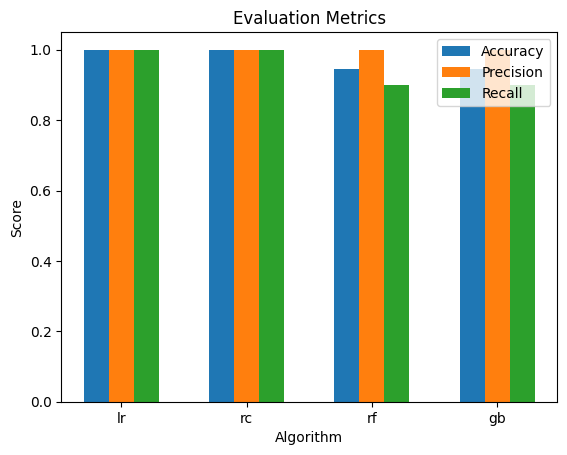

In [26]:
accuracy_scores = []
precision_scores = []
recall_scores = []

for algo, model in fit_models.items():
    yhat = model.predict(X_test)
    accuracy = accuracy_score(y_test.values, yhat)
    precision = precision_score(y_test.values, yhat, average="binary", pos_label="up")
    recall = recall_score(y_test.values, yhat, average="binary", pos_label="up")
    
    accuracy_scores.append(accuracy)
    precision_scores.append(precision)
    recall_scores.append(recall)

    print(f"{algo}: Accuracy - {accuracy:.4f}, Precision - {precision:.4f}, Recall - {recall:.4f}")

# Plotting the evaluation metrics
x = np.arange(len(fit_models))
width = 0.2

fig, ax = plt.subplots()
rects1 = ax.bar(x - width, accuracy_scores, width, label='Accuracy')
rects2 = ax.bar(x, precision_scores, width, label='Precision')
rects3 = ax.bar(x + width, recall_scores, width, label='Recall')

ax.set_xticks(x)
ax.set_xticklabels(fit_models.keys())
ax.legend()

ax.set_xlabel('Algorithm')
ax.set_ylabel('Score')
ax.set_title('Evaluation Metrics')

plt.show()

Both logistic regression and ridgeclassifier produced the best results

#### Save the best model (logistic regression)

In [27]:
with open ('pushupsDetector.pk1', 'wb') as f:
    pickle.dump(fit_models['lr'], f)

### Make a prediction with saved model

#### Use local video file / live stream as video input flags

In [96]:
global use_live_feed
global use_saved_video

use_live_feed = False
use_saved_video = False

#### Choose video input menu

In [97]:
import tkinter as tk

# Button to set video source as live feed
def live_feed_button():
    global use_live_feed
    use_live_feed = True
    window.destroy()  # Close the window

# Button to set video source as saved video file
def saved_video_button():
    global use_saved_video
    use_saved_video = True
    window.destroy()  # Close the window

# Create the main window
window = tk.Tk()

# Set the window size
window.geometry("400x300")

# Create "Use live feed" Button
button1 = tk.Button(window, text="Use live feed", command=live_feed_button)
button1.pack()

# Create "Use saved video" Button
button2 = tk.Button(window, text="Use saved video", command=saved_video_button)
button2.pack()

# Run the main event loop
window.mainloop()

#### import and play sounds

In [98]:
import simpleaudio as sa

sound_file_path = "sfx/keep_up_sfx.wav"
sound_object = sa.WaveObject.from_wave_file(sound_file_path)

In [99]:
def play_sound():
    play_obj = sound_object.play()

#### import saved model

In [100]:
import pickle

In [101]:
with open('pushupsDetector.pk1', 'rb') as f:
    model = pickle.load(f)

In [102]:
model

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('logisticregression', LogisticRegression())])

In [103]:
import cv2
import mediapipe as mp
import numpy as np
import pandas as pd

In [104]:
landmarks = ['class']
for val in range(1, 33+1):
    landmarks += ['x{}'.format(val), 'y{}'.format(val), 'z{}'.format(val), 'v{}'.format(val)]

In [105]:
mp_pose = mp.solutions.pose
mp_drawing = mp.solutions.drawing_utils

In [106]:
import requests

# Set video source as the user has chosen. If live feed was chosen but there is no connection, use saved video file instead
if use_live_feed:
    try:
        response = requests.get("http://192.168.1.155:8080")
        if response.status_code == 200:
            print("Connection successful")
            cap = cv2.VideoCapture("http://192.168.1.155:8080/video")
        else:
            print("Connection failed with status code:", response.status_code)
        
    except requests.exceptions.RequestException as e:
        print("Connection failed, using saved video file instead:", str(e))
        cap = cv2.VideoCapture('videos/pushups2.mp4')

elif use_saved_video:
    cap = cv2.VideoCapture('videos/pushups2.mp4')

counter = 0
current_stage = ''
with mp_pose.Pose(min_detection_confidence=0.5, min_tracking_confidence=0.5) as pose:
    while cap.isOpened():
        try:
            ret, frame = cap.read()

            image = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
            image.flags.writeable = False

            results = pose.process(image)

            image.flags.writeable = True
            image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)

            mp_drawing.draw_landmarks(image, results.pose_landmarks, mp_pose.POSE_CONNECTIONS,
                                    mp_drawing.DrawingSpec(color=(245,177,66), thickness=2, circle_radius=4),
                                    mp_drawing.DrawingSpec(color=(245,66,230), thickness=2, circle_radius=2)
                                    )
        except:
            break
        try:
            row = np.array([[res.x, res.y, res.z, res.visibility] for res in results.pose_landmarks.landmark]).flatten().tolist()
            X = pd.DataFrame([row], columns=landmarks[1:])
            pushup_label = model.predict(X)[0]
            pushup_prob = model.predict_proba(X)[0]
            print(pushup_label, pushup_prob)

            if pushup_label == 'down' and pushup_prob[pushup_prob.argmax()] >= 0.7:
                current_stage = 'down'
            elif current_stage == 'down' and pushup_label == 'up' and pushup_prob[pushup_prob.argmax()] >= 0.7:
                current_stage = 'up'
                counter += 1
                print(current_stage)

                # for each 10 pushups, play "keep up" sound
                if counter % 10 == 0:
                    play_sound()
                """
                # Record when changed to'up'
                event_time = time.time()

                # Wait for 2 seconds since changed to 'up'
                time.sleep(3) 

                # Check if 3 seconds have passed since the event
                current_time = time.time()
                elapsed_time = current_time - event_time
                if elapsed_time >= 3 and pushup_label == 'up':
                    play_obj = sound_object.play()
                    play_obj.wait_done()
                else:
                    pass
                """


            # Display pushup action label
            cv2.rectangle(image, (0,0), (250, 60), (245, 117, 16), -1)

            cv2.putText(image, 'action',
                        (95,12), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0,0,0), 1, cv2.LINE_AA)
            cv2.putText(image, pushup_label.split(' ')[0],
                        (90,40), cv2.FONT_HERSHEY_SIMPLEX, 1, (255,255,255), 2, cv2.LINE_AA)
            
            # Display probability
            cv2.putText(image, 'prob',
                        (15,12), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0,0,0), 1, cv2.LINE_AA)
            cv2.putText(image, str(round(pushup_prob[np.argmax(pushup_prob)], 2)),
                        (10,40), cv2.FONT_HERSHEY_SIMPLEX, 1, (255,255,255), 2, cv2.LINE_AA)
            
            # Display pushups count
            cv2.putText(image, 'count',
                        (180,12), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0,0,0), 1, cv2.LINE_AA)
            cv2.putText(image, str(counter),
                        (175,40), cv2.FONT_HERSHEY_SIMPLEX, 1, (255,255,255), 2, cv2.LINE_AA)
            
        except Exception as e:
            pass

        cv2.imshow('Video', image)
        if cv2.waitKey(1) & 0xFF == ord('q'):
            break

cap.release()
cv2.destroyAllWindows()

up [8.14646765e-04 9.99185353e-01]
up [9.17227173e-04 9.99082773e-01]
up [9.07982133e-04 9.99092018e-01]
up [9.11041240e-04 9.99088959e-01]
up [8.95643741e-04 9.99104356e-01]
up [8.82890670e-04 9.99117109e-01]
up [8.86267747e-04 9.99113732e-01]
up [9.20169482e-04 9.99079831e-01]
up [9.12615821e-04 9.99087384e-01]
up [9.35322794e-04 9.99064677e-01]
up [9.73423814e-04 9.99026576e-01]
up [9.97384459e-04 9.99002616e-01]
up [0.00101101 0.99898899]
up [0.00102364 0.99897636]
up [0.00103522 0.99896478]
up [0.00104058 0.99895942]
up [0.0010667 0.9989333]
up [0.00110182 0.99889818]
up [0.00111889 0.99888111]
up [0.00120071 0.99879929]
up [0.00125297 0.99874703]
up [0.00125813 0.99874187]
up [0.00123998 0.99876002]
up [0.00121741 0.99878259]
up [0.00119601 0.99880399]
up [0.00116949 0.99883051]
up [0.00105675 0.99894325]
up [9.47023072e-04 9.99052977e-01]
up [9.13506767e-04 9.99086493e-01]
up [8.9787995e-04 9.9910212e-01]
up [9.67183111e-04 9.99032817e-01]
up [0.0011932 0.9988068]
up [0.00177432

In [107]:
print('f')

f
